In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [ ]:
#read in files
#already been split into training people and testing groups
#made from impute2

testing_SNPs = pd.read_csv('testing.txt', delimiter=' ', header = None)
training_SNPs = pd.read_csv('training.txt', delimiter = ' ', header = None)
#map22 = pd.read_csv('map22.txt', delimiter = '\t', header = None)
map22_2 = pd.read_csv('chr22.txt', delimiter = ' ', header = None)

In [ ]:
#read in map
#find how many SNPs in our training/testing SNPs (they're the same...) are also in our map

#we only have 250 people in our training data
#print(map22[:6][0]) #first col is physical position, second is recombination rate with the next SNP, \
#third is genetic map in cM
print(training_SNPs.shape) 

training_SNPs_arr = training_SNPs[:][2].to_numpy()
SNPs = int(testing_SNPs.shape[0])

#this map doesn't have many cM distances in it
#map22_arr_pos = map22.loc[:][0].to_numpy()

#this map has more data in it
chr22_arr = map22_2.loc[:8000][1].to_numpy() #hard coding to make file smaller (our SNPs all in first 8k)
chr22_cM = map22_2.loc[:8000][2].to_numpy()

#turns out there are a few duplicates in my chr22 map
uniques = np.unique(chr22_arr)
print(len(uniques))

#find indices in training_SNPs_arr where we have a cM distance
indices_in_SNPs = np.where(np.in1d(training_SNPs_arr,chr22_arr))
indices_in_map = np.where(np.in1d(chr22_arr, training_SNPs_arr))

#format into something nicer
idx_map = indices_in_map[0]
idx_SNP = indices_in_SNPs[0]


In [ ]:
#make a 2 column matrix
#first column = SNP position
#second column = cM distance
#if no cM distance, put -1 for now

cM_map = np.zeros((SNPs,2))
for SNP in range(SNPs):
    #first column = SNP position
    cM_map[SNP, 0] = training_SNPs_arr[SNP]
    
    #check if the SNP is found by indices_in_SNPs
    if SNP in idx_SNP:
        #ind = index for which indices_in_SNPs[index] == SNP
        ind = np.where(idx_SNP == SNP)
        cM_map[SNP, 1] = chr22_cM[idx_map[ind][0]]
    else:
        #unknowns get -1
        cM_map[SNP, 1] = -1
        
#going to initialize this first value to a cM value of 0
cM_map[0][1] = 0


In [ ]:
#need to infer missing cM values
#going to just find average value (is this a valid assumption?)

for SNP in range(SNPs):
    counter = 1
    if cM_map[SNP][1] < 0:
        i = 0
        prev_known_SNP = cM_map[SNP-1][1]
        while (cM_map[SNP + i][1] < 0):
            counter +=1 
            i += 1
        next_known_SNP = cM_map[SNP + i][1]
        cM_map[SNP][1] = (next_known_SNP - prev_known_SNP)/counter + prev_known_SNP
      
    
cM_dist = cM_map[:, 1] + 1
print(cM_dist)

In [ ]:
#convert testing file into 3 part prob dist file
#for each SNP, each person, who is 100% AA, AB, or BB, which is written as 00, 01, or 11, gets 
#turned into one number for AA, one number for AB, one number for BB (so 1, 0,0 as AA, 0, 1, 0 as
#AB, and 0,0,1 for BB)

people = int((testing_SNPs.shape[1]-5) / 2.0)

testing_dist = np.zeros((SNPs, people * 3))
maj_homozygous_test = np.zeros((SNPs, people))
heterozygous_test = np.zeros((SNPs, people))
min_homozygous_test = np.zeros((SNPs, people))

for SNP in range(SNPs):
    for person in range(people):
        if (testing_SNPs.loc[SNP, 5 + person*2] == 0) and (testing_SNPs.loc[SNP, 6 + person*2] == 0):
            maj_homozygous_test[SNP, person] = 1
        elif (testing_SNPs.loc[SNP, 5 + person*2] == 1) and (testing_SNPs.loc[SNP, 6 + person*2] == 0):
            heterozygous_test[SNP, person] = 1
        elif (testing_SNPs.loc[SNP, 5 + person*2] == 0) and (testing_SNPs.loc[SNP, 6 + person*2] == 1):
            heterozygous_test[SNP, person] = 1
        elif (testing_SNPs.loc[SNP, 5 + person*2] == 1) and (testing_SNPs.loc[SNP, 6 + person*2] == 1):
            min_homozygous_test[SNP, person] = 1
            


In [ ]:
#convert training file into 3 part prob dist file
#for each SNP, each person, who is 100% AA, AB, or BB, which is written as 00, 01, or 11, gets 
#turned into one number for AA, one number for AB, one number for BB (so 1, 0,0 as AA, 0, 1, 0 as
#AB, and 0,0,1 for BB)

people_training = int((training_SNPs.shape[1]-5) / 2.0)

training_dist = np.zeros((SNPs, people_training * 3))
maj_homozygous_train = np.zeros((SNPs, people_training))
heterozygous_train = np.zeros((SNPs, people_training))
min_homozygous_train = np.zeros((SNPs, people_training))

for SNP in range(SNPs):
    for person in range(people_training):
        if (training_SNPs.loc[SNP, 5 + person*2] == 0) and (training_SNPs.loc[SNP, 6 + person*2] == 0):
            maj_homozygous_train[SNP, person] = 1
        elif (training_SNPs.loc[SNP, 5 + person*2] == 1) and (training_SNPs.loc[SNP, 6 + person*2]) == 0:
            heterozygous_train[SNP, person] = 1
        elif (training_SNPs.loc[SNP, 5 + person*2] == 0) and (training_SNPs.loc[SNP, 6 + person*2] == 1):
            heterozygous_train[SNP, person] = 1
        elif (training_SNPs.loc[SNP, 5 + person*2] == 1) and (training_SNPs.loc[SNP, 6 + person*2] == 1):
            min_homozygous_train[SNP, person] = 1


In [17]:
#constants, based on our data
maj_homo_train_T = maj_homozygous_train.transpose()
hetero_train_T = heterozygous_train.transpose()
min_homo_train_T = min_homozygous_train.transpose()

maj_homo_test_T = maj_homozygous_test.transpose()
hetero_test_T = heterozygous_test.transpose()
min_homo_test_T = min_homozygous_test.transpose()

thin_var = 0.1
idx_imputing = np.random.choice(int((maj_homo_train_T.shape[1])), int((maj_homo_train_T.shape[1]) * thin_var), replace = False)
missing_idx = np.sort(idx_imputing)
missing_idx = list(missing_idx)
missing_indices = []
for x in missing_idx:
    if (x < offset):
        missing_idx.remove(x)
    elif (x > int((maj_homo_train_T.shape[1])) - offset - 1):
        missing_idx.remove(x)
    else:
        missing_indices.append(x)    

In [82]:
#THIS IS CLEARLY THE GOOD ONE
import time
def training_faster(offset, thin_var):
    t1 = time.time()
    np.random.seed(0)

    #create indices that will be "missing"
    idx_imputing = np.random.choice(int((maj_homo_train_T.shape[1])), int((maj_homo_train_T.shape[1]) * thin_var), replace = False)
    missing_idx = np.sort(idx_imputing)
    missing_idx = list(missing_idx)
    missing_indices = []
    for x in missing_idx:
        if (x < offset):
            missing_idx.remove(x)
        elif (x > int((maj_homo_train_T.shape[1])) - offset - 1):
            missing_idx.remove(x)
        else:
            missing_indices.append(x)    
    kept_indices = [row for row in range(maj_homo_train_T.shape[1]) if row not in missing_indices]

    
    imputable_maj_train = maj_homo_train_T[:, offset:maj_homo_train_T.shape[1]-offset]
    imputable_min_train = min_homo_train_T[:, offset:maj_homo_train_T.shape[1]-offset]
    imputable_het_train = hetero_train_T[:, offset:maj_homo_train_T.shape[1]-offset]

    imputable_snps = imputable_maj_train[1]
    mega_training_data_maj = np.zeros((people_training * len(imputable_snps), 2*offset))
    mega_training_data_min = np.zeros((people_training * len(imputable_snps), 2*offset))
    mega_training_data_het = np.zeros((people_training * len(imputable_snps), 2*offset))
    mega_labels_maj = np.zeros((len(imputable_snps) * people_training))
    mega_labels_min = np.zeros((len(imputable_snps) * people_training))
    mega_labels_het = np.zeros((len(imputable_snps) * people_training))

                
 
  
    maj_train_scaled = (((((maj_homo_train_T * 2)+1)*0.5)-1)*2)
    min_train_scaled = (((((min_homo_train_T * 2)+1)*0.5)-1)*2)
    het_train_scaled = (((((hetero_train_T * 2)+1)*0.5)-1)*2)

    #maj_train_scaled = maj_homo_train_T +1
    #min_train_scaled = min_homo_train_T +1
    #het_train_scaled = hetero_train_T +1    
    
    maj_train_scaled = maj_train_scaled * cM_dist
    min_train_scaled = min_train_scaled * cM_dist
    het_train_scaled = het_train_scaled * cM_dist
    
    correct_size_ones = np.ones((maj_train_scaled.shape[0], 2*offset))
    
    for SNP in range((maj_homo_train_T.shape[1] - offset*2), (maj_homo_train_T.shape[1] - offset)):
    #for SNP in range(offset, (maj_homo_train_T.shape[1] - offset)): #offset to ncol maj_homo_train_T-offset +1
        print(SNP)
        #the SNP being imputed - the label
        test_val_maj = maj_homo_train_T[:,SNP]
        test_val_min = min_homo_train_T[:,SNP]
        test_val_het = hetero_train_T[:,SNP]

        test_val_cM = cM_dist[SNP]
        
        #calculate the data
        below_start_offset = SNP - 1
        while below_start_offset not in kept_indices:
            below_start_offset -= 1
        below_index = kept_indices.index(below_start_offset)

        above_start_offset = SNP + 1
        while above_start_offset not in kept_indices:
            above_start_offset += 1
        above_index = kept_indices.index(above_start_offset)
        
        idx_range = np.r_[kept_indices[(below_index-offset+1):below_index+1],
             kept_indices[above_index:above_index+offset]]
        idx_range_int = [int(i) for i in idx_range]

        train_val_maj = maj_train_scaled[:,idx_range_int]
        train_val_min = min_train_scaled[:,idx_range_int]
        train_val_het = het_train_scaled[:,idx_range_int]
        
        #train_val_maj = np.abs(train_val_maj - test_val_cM * correct_size_ones)
        #train_val_maj = np.abs(train_val_maj - np.max(train_val_maj))

        train_val_maj = np.abs(np.abs(train_val_maj) - test_val_cM * correct_size_ones)
        train_val_maj = np.nan_to_num(np.reciprocal(train_val_maj))
        
        #train_val_min = np.abs(train_val_min - test_val_cM * correct_size_ones)
        #train_val_min = np.abs(train_val_min - np.max(train_val_min))

        train_val_min = np.abs(np.abs(train_val_min) - test_val_cM * correct_size_ones)
        train_val_min = np.nan_to_num(np.reciprocal(train_val_min))

        #train_val_het = np.abs(train_val_het - test_val_cM * correct_size_ones)
        #train_val_het = np.abs(train_val_het - np.max(train_val_het))

        train_val_het = np.abs(np.abs(train_val_het) - test_val_cM * correct_size_ones)
        train_val_het = np.nan_to_num(np.reciprocal(train_val_het))

        
        #for val in range(len(train_val_maj)):
        #    train_val_maj[val] = 1.0 / np.abs(test_val_cM - train_val_maj[val])
        #    train_val_min[val] = 1.0 / np.abs(test_val_cM - train_val_min[val])
        #    train_val_het[val] = 1.0 / np.abs(test_val_cM - train_val_het[val])

        
        #add labels to label vector
        mega_labels_maj[((SNP-offset) * people_training) : ((SNP-offset + 1) * people_training)] = maj_homo_train_T[:,SNP]
        mega_labels_min[((SNP-offset) * people_training) : ((SNP-offset + 1) * people_training)] = min_homo_train_T[:,SNP]
        mega_labels_het[((SNP-offset) * people_training) : ((SNP-offset + 1) * people_training)] = hetero_train_T[:,SNP]
        
        #add to the mega data
        mega_training_data_maj[(SNP-offset) * people_training : (SNP-offset + 1) * people_training, :] = train_val_maj
        mega_training_data_min[(SNP-offset) * people_training : (SNP-offset + 1) * people_training, :] = train_val_min
        mega_training_data_het[(SNP-offset) * people_training : (SNP-offset + 1) * people_training, :] = train_val_het
        print(np.max(mega_training_data_maj[(SNP-offset) * people_training : (SNP-offset + 1) * people_training, :]))


    snpX_maj = RandomForestClassifier(n_estimators = 400, max_depth=6, class_weight = "balanced")
    snpX_min = RandomForestClassifier(n_estimators = 400, max_depth=6, class_weight = "balanced")
    snpX_het = RandomForestClassifier(n_estimators = 400, max_depth=6, class_weight = "balanced")

    snpX_maj.fit(mega_training_data_maj, mega_labels_maj)
    snpX_min.fit(mega_training_data_min, mega_labels_min)
    snpX_het.fit(mega_training_data_het, mega_labels_het)
    t2 = time.time()
    total_time = t2-t1
    return total_time, snpX_maj, snpX_min, snpX_het

In [ ]:
#saving time vals
time_off_25_thin_0p1 = 2562.2098598480225 

In [83]:
#REWRITE THIS
import math
def testing_faster(offset, thin_var, snpX_maj, snpX_min, snpX_het):
    t1 = time.time()

    np.random.seed(0)

    #create indices that will be "missing"
    idx_imputing = np.random.choice(int((maj_homo_test_T.shape[1])), int((maj_homo_test_T.shape[1]) * thin_var), replace = False)
    missing_idx = np.sort(idx_imputing)
    missing_idx = list(missing_idx)
    missing_indices = []
    for x in missing_idx:
        if (x < offset):
            missing_idx.remove(x)
        elif (x > int((maj_homo_test_T.shape[1])) - offset - 1):
            missing_idx.remove(x)
        else:
            missing_indices.append(x)    
    kept_indices = [row for row in range(maj_homo_test_T.shape[1]) if row not in missing_indices]
    
    H_scores_final = []
    
    maj_test_scaled = maj_homo_test_T +1
    min_test_scaled = min_homo_test_T +1
    het_test_scaled = hetero_test_T +1    
    
    maj_train_scaled = maj_test_scaled * cM_dist
    min_train_scaled = min_test_scaled * cM_dist
    het_train_scaled = het_test_scaled * cM_dist
    
    correct_size_ones = np.ones((maj_test_scaled.shape[0], 2*offset))
    
    for SNP in missing_indices:

        #create correct labels
        test_label_maj = maj_homo_test_T[:,SNP]
        test_label_min = min_homo_test_T[:,SNP]
        test_label_het = hetero_test_T[:,SNP]

        test_val_cM = cM_dist[SNP]

        #calculate the data
        below_start_offset = SNP - 1
        while below_start_offset not in kept_indices:
            below_start_offset -= 1
        below_index = kept_indices.index(below_start_offset)

        above_start_offset = SNP + 1
        while above_start_offset not in kept_indices:
            above_start_offset += 1
        above_index = kept_indices.index(above_start_offset)
        
        idx_range = np.r_[kept_indices[(below_index-offset+1):below_index+1],
             kept_indices[above_index:above_index+offset]]
        idx_range_int = [int(i) for i in idx_range]

        test_val_maj = maj_test_scaled[:,idx_range_int]
        test_val_min = min_test_scaled[:,idx_range_int]
        test_val_het = het_test_scaled[:,idx_range_int]
        
        #test_val_maj = np.abs(test_val_maj - test_val_cM * correct_size_ones)
        #test_val_maj = np.abs(test_val_maj - np.max(test_val_maj))
        
        test_val_maj = np.abs(np.abs(test_val_maj) - test_val_cM * correct_size_ones)
        test_val_maj = np.nan_to_num(np.reciprocal(test_val_maj))
        
        #test_val_min = np.abs(test_val_min - test_val_cM * correct_size_ones)
        #test_val_min = np.abs(test_val_min - np.max(test_val_min))

        test_val_min = np.abs(np.abs(test_val_min) - test_val_cM * correct_size_ones)
        test_val_min = np.nan_to_num(np.reciprocal(test_val_min))

        #test_val_het = np.abs(test_val_het - test_val_cM * correct_size_ones)
        #test_val_het = np.abs(test_val_het - np.max(test_val_het))
        
        test_val_het = np.abs(np.abs(test_val_het) - test_val_cM * correct_size_ones)
        test_val_het = np.nan_to_num(np.reciprocal(test_val_het))

        
        
        predict_maj = snpX_maj.predict(test_val_maj)
        predict_min = snpX_min.predict(test_val_min)
        predict_het = snpX_het.predict(test_val_het)


        #Accuracy for Hellinger score
        probs_maj = snpX_maj.predict_proba(test_val_maj)
        probs_min = snpX_min.predict_proba(test_val_min)
        probs_het = snpX_het.predict_proba(test_val_het)

        #Normalize for Hellinger score
        #if any are all one dimension rather than two, means it is never that. Add a second col anyway
        '''probs_het = np.zeros((probs_hetero.shape[0], 2))
        if probs_hetero.shape[1] == 1:
            for i in range((probs_hetero.shape[0])):
                probs_het[i][0] = probs_hetero[i]
        else:
            probs_het = probs_hetero

        probs_maj = np.zeros((probs_maj_homo.shape[0], 2))
        if probs_maj_homo.shape[1] == 1:
            for i in range((probs_maj_homo.shape[0])):
                probs_maj[i][0] = probs_maj_homo[i]
        else:
            probs_maj = probs_maj_homo


        probs_min = np.zeros((probs_min_homo.shape[0], 2))
        if probs_min_homo.shape[1] == 1:
            for i in range((probs_min_homo.shape[0])):
                probs_min[i][0] = probs_min_homo[i]
        else:
            probs_min = probs_min_homo'''


        #HERE --> create "normalized" distributions for the three
        prob_dist_predict = np.zeros(( probs_min.shape[0], 3))
        for person in range(probs_min.shape[0]):
            total = probs_min[person][1] + probs_maj[person][1] + probs_het[person][1]
            prob_dist_predict[person][0] = probs_maj[person][1] / total
            prob_dist_predict[person][1] = probs_het[person][1] / total
            prob_dist_predict[person][2] = probs_min[person][1] / total

        #calculate actual prob_dist_actual
        prob_dist_actual = np.zeros((probs_min.shape[0], 3))
        H_score = []

        for person in range((probs_min.shape[0])):
            sum_total = test_label_maj[person] + test_label_het[person] +\
            test_label_min[person]
            prob_dist_actual[person][0] = test_label_maj[person] / sum_total
            prob_dist_actual[person][1] = test_label_het[person] / sum_total
            prob_dist_actual[person][2] = test_label_min[person] / sum_total

            sqrt_sum = math.sqrt(prob_dist_actual[person][0] * prob_dist_predict[person][0]) + \
                math.sqrt(prob_dist_actual[person][1] * prob_dist_predict[person][1]) + \
                math.sqrt(prob_dist_actual[person][2] * prob_dist_predict[person][2])
            if sqrt_sum > 1.0:
                sqrt_sum = 1.0
            H_score.append(1 - math.sqrt(1-sqrt_sum))
        H_scores_final.append(H_score)
    t2 = time.time()
    total_time = t2-t1

    return H_scores_final, total_time



In [81]:
offset = 25
thin_var = 0.1
time_off25_thin0p1_train, snpX_maj, snpX_min, snpX_het = training_faster(offset = offset, thin_var = 0.1)
H_scores_off25_thin0p1, time_off25_thin0p1_test = testing_faster(offset, thin_var, snpX_maj, snpX_min, snpX_het)

flat_H_off25_thin0p1 = [item for sublist in H_scores_off25_thin0p1 for item in sublist]

np.savetxt("H_scores_off25_thin0p1_RF", flat_H_off25_thin0p1, delimiter = ' ')
print(time_off25_thin0p1_train, time_off25_thin0p1_test)


4950
44871.803501742055
44871.803501742055
4951
44871.803501742055
44871.803501742055
4952
28794.73586140491
28794.73586140491
4953
28794.73586140491
28794.73586140491
4954
23718.62500279407
23718.62500279407
4955
11050.402654547572
11050.402654547572
4956
11050.4026546018
11050.4026546018
4957
19931.65435726536
19931.65435726536
4958
31656.158405072492
31656.158405072492
4959
31656.158405072492
31656.158405072492
4960
71428.57142765033
71428.57142765033
4961
1595227.0796763485
1595227.0796763485
4962
71428.57142765033
71428.57142765033
4963
158687.84197122647
158687.84197122647
4964
59507.976151708244
59507.976151708244
4965
233174.153110585
233174.153110585
4966
233174.153110585
233174.153110585
4967
95238.09524089513
95238.09524089513
4968
95238.09523686711
95238.09523686711
4969
76177.5912929862
76177.5912929862
4970
76177.5912929862
76177.5912929862
4971
525000.5251370175
525000.5251370175
4972
525000.5251370175
525000.5251370175
4973
323076.7242285458
323076.7242285458
4974
55555

KeyboardInterrupt: 

In [69]:
#debug
np.random.seed(0)

#create indices that will be "missing"
idx_imputing = np.random.choice(int((maj_homo_train_T.shape[1])), int((maj_homo_train_T.shape[1]) * thin_var), replace = False)
missing_idx = np.sort(idx_imputing)
missing_idx = list(missing_idx)
missing_indices = []
for x in missing_idx:
    if (x < offset):
        missing_idx.remove(x)
    elif (x > int((maj_homo_train_T.shape[1])) - offset - 1):
        missing_idx.remove(x)
    else:
        missing_indices.append(x)    
kept_indices = [row for row in range(maj_homo_train_T.shape[1]) if row not in missing_indices]


imputable_maj_train = maj_homo_train_T[:, offset:maj_homo_train_T.shape[1]-offset]
imputable_min_train = min_homo_train_T[:, offset:maj_homo_train_T.shape[1]-offset]
imputable_het_train = hetero_train_T[:, offset:maj_homo_train_T.shape[1]-offset]

imputable_snps = imputable_maj_train[1]
mega_training_data_maj = np.zeros((people_training * len(imputable_snps), 2*offset))
mega_training_data_min = np.zeros((people_training * len(imputable_snps), 2*offset))
mega_training_data_het = np.zeros((people_training * len(imputable_snps), 2*offset))
mega_labels_maj = np.zeros((len(imputable_snps) * people_training))
mega_labels_min = np.zeros((len(imputable_snps) * people_training))
mega_labels_het = np.zeros((len(imputable_snps) * people_training))




maj_train_scaled = (((((maj_homo_train_T * 2)+1)*0.5)-1)*2)
min_train_scaled = (((((min_homo_train_T * 2)+1)*0.5)-1)*2)
het_train_scaled = (((((hetero_train_T * 2)+1)*0.5)-1)*2)

#maj_train_scaled = maj_homo_train_T +1
#min_train_scaled = min_homo_train_T +1
#het_train_scaled = hetero_train_T +1    

maj_train_scaled = maj_train_scaled * cM_dist
min_train_scaled = min_train_scaled * cM_dist
het_train_scaled = het_train_scaled * cM_dist

correct_size_ones = np.ones((maj_train_scaled.shape[0], 2*offset))

#for SNP in range(offset, (maj_homo_train_T.shape[1] - offset)): #offset to ncol maj_homo_train_T-offset +1

SNP = 3456
print(SNP)
#the SNP being imputed - the label
test_val_maj = maj_homo_train_T[:,SNP]
test_val_min = min_homo_train_T[:,SNP]
test_val_het = hetero_train_T[:,SNP]

test_val_cM = cM_dist[SNP]

#calculate the data
below_start_offset = SNP - 1
while below_start_offset not in kept_indices:
    below_start_offset -= 1
below_index = kept_indices.index(below_start_offset)

above_start_offset = SNP + 1
while above_start_offset not in kept_indices:
    above_start_offset += 1
above_index = kept_indices.index(above_start_offset)

idx_range = np.r_[kept_indices[(below_index-offset+1):below_index+1],
     kept_indices[above_index:above_index+offset]]
idx_range_int = [int(i) for i in idx_range]

train_val_maj = maj_train_scaled[:,idx_range_int]
train_val_min = min_train_scaled[:,idx_range_int]
train_val_het = het_train_scaled[:,idx_range_int]

#train_val_maj = np.abs(train_val_maj - test_val_cM * correct_size_ones)
#train_val_maj = np.abs(train_val_maj - np.max(train_val_maj))

train_val_maj = np.abs(np.abs(train_val_maj) - test_val_cM * correct_size_ones)
train_val_maj = np.reciprocal(train_val_maj)

#train_val_min = np.abs(train_val_min - test_val_cM * correct_size_ones)
#train_val_min = np.abs(train_val_min - np.max(train_val_min))

train_val_min = np.abs(np.abs(train_val_min) - test_val_cM * correct_size_ones)
train_val_min = np.reciprocal(train_val_min)

#train_val_het = np.abs(train_val_het - test_val_cM * correct_size_ones)
#train_val_het = np.abs(train_val_het - np.max(train_val_het))

train_val_het = np.abs(np.abs(train_val_het) - test_val_cM * correct_size_ones)
train_val_het = np.reciprocal(train_val_het)

print(np.max(train_val_maj))

3456
5641218.516941938


In [63]:
#np.savetxt("H_data_50%mask_25offset_RF", flat_H_offset25_mask, delimiter = ' ')
#print(time_off25_thin0p1_train)
#2636.1913940906525

print(np.max(mega_training_data_maj))

0.0


In [39]:
flat_H_off25_thin0p1 = [item for sublist in H_scores_off25_thin0p1 for item in sublist]

np.savetxt("H_scores_off25_thin0p1_RF", flat_H_off25_thin0p1, delimiter = ' ')
print(time_off25_thin0p1_test)


150.83181881904602


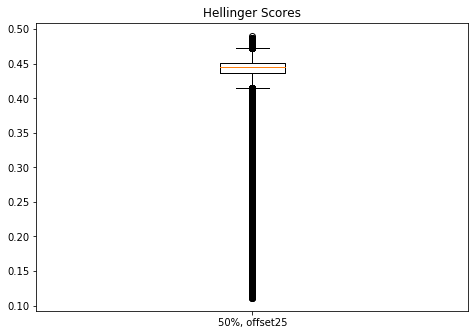

In [41]:
import matplotlib.pyplot as plt

fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
#ax.set_xticks([1, 2, 3, 4, 5, 6, 7])
ax.set_xticklabels(['50%, offset25'])
ax.boxplot(flat_H_off25_thin0p1, showfliers=True)
plt.title("Hellinger Scores")

plt.show()



In [ ]:
#PRETTY SURE I CAN STOP HERE
#Transpose the matrices so they are people # rows and SNP # columns
maj_homo_train_T = maj_homozygous_train.transpose()
hetero_train_T = heterozygous_train.transpose()
min_homo_train_T = min_homozygous_train.transpose()

label_maj_homo = np.zeros((maj_homo_train_T.shape[0]))
label_min_homo = np.zeros((min_homo_train_T.shape[0]))
label_hetero = np.zeros((hetero_train_T.shape[0]))

for i in range(maj_homo_train_T.shape[0]):
    label_maj_homo[i] =  maj_homo_train_T[i][idx_snp]
    label_min_homo[i] = min_homo_train_T[i][idx_snp]
    label_hetero[i] = hetero_train_T[i][idx_snp]

label_maj_homo_cM = cM_map[idx_snp][1]
new_training_scaled_cM = np.zeros((people_training, 2*offset))
new_training_scaled_cM_min = np.zeros((people_training, 2*offset))
new_training_scaled_cM_hetero = np.zeros((people_training, 2*offset))

diffs = np.zeros((people_training, 2*offset))

#creates models
diff_val = 0.001
#for the 2*offset SNPs being used as data
for cMpos in range(2*offset):
    for person in range(people_training):
        #need to account for not using the actual SNP being imputed
        if cMpos < offset:
            #calculate cM pos difference between SNP being imputed + reference SNP
            diff = np.abs(label_maj_homo_cM - cM_map[idx_snp - offset+ cMpos][1])
            diffs[person][cMpos] = diff
            #if difference is zero, they have same cM pos position and should stick together
            #this only happens at the very first few SNPs (probably)
            if diff == 0:  
                diff = diff_val #can change this value
            
            unscaled_data = maj_homo_train_T[person][idx_snp - offset + cMpos]
            unscaled_data_min = min_homo_train_T[person][idx_snp - offset + cMpos]
            unscaled_data_hetero = hetero_train_T[person][idx_snp - offset + cMpos]

            #set 0 vals to -1 (so we don't just set ~1/2+ of our data to 0)
            if unscaled_data == 0:
                unscaled_data = -1
            #new training data is scaled by reciprocal of difference
            #so close SNPs have higher impact on imputed val
            new_training_scaled_cM[person][cMpos] = unscaled_data * (1.0 / diff )
            new_training_scaled_cM_min[person][cMpos] = unscaled_data_min * (1.0 / diff )
            new_training_scaled_cM_hetero[person][cMpos] = unscaled_data_hetero * (1.0 / diff )

        else:
            #print("cMpos", cMpos, "cMpos Dist", cM_map[idx_snp - offset+ cMpos +1][1])
            diff = np.abs(label_maj_homo_cM - cM_map[idx_snp - offset+ cMpos +1][1])
            diffs[person][cMpos] = diff

            if diff == 0:  
                diff = diff_val 
            unscaled_data = maj_homo_train_T[person][idx_snp - offset+ cMpos + 1]
            unscaled_data_min = min_homo_train_T[person][idx_snp - offset + cMpos + 1]
            unscaled_data_hetero = hetero_train_T[person][idx_snp - offset + cMpos + 1]

            #set 0 vals to -1 (so we don't just set ~1/2+ of our data to 0)
            if unscaled_data == 0:
                unscaled_data = -1
            #new training data is scaled by reciprocal of difference
            #so close SNPs have higher impact on imputed val
            new_training_scaled_cM[person][cMpos] = unscaled_data * (1.0 / diff )
            new_training_scaled_cM_min[person][cMpos] = unscaled_data_min * (1.0 / diff )
            new_training_scaled_cM_hetero[person][cMpos] = unscaled_data_hetero * (1.0 / diff )


snpX_maj = RandomForestClassifier(n_estimators = 400, max_depth=6, class_weight = "balanced")
snpX_min = RandomForestClassifier(n_estimators = 400, max_depth=6, class_weight = "balanced")
snpX_hetero = RandomForestClassifier(n_estimators = 400, max_depth=6, class_weight = "balanced")

snpX_maj.fit(new_training_scaled_cM, label_maj_homo)
snpX_min.fit(new_training_scaled_cM_min, label_min_homo)
snpX_hetero.fit(new_training_scaled_cM_hetero, label_hetero)


In [ ]:
#function to run through many times (as we do our model)
import math

def train_and_test(offset, idx_snp):
    #training
    label_maj_homo = np.zeros((maj_homo_train_T.shape[0]))
    label_min_homo = np.zeros((min_homo_train_T.shape[0]))
    label_hetero = np.zeros((hetero_train_T.shape[0]))

    for i in range(maj_homo_train_T.shape[0]):
        label_maj_homo[i] =  maj_homo_train_T[i][idx_snp]
        label_min_homo[i] = min_homo_train_T[i][idx_snp]
        label_hetero[i] = hetero_train_T[i][idx_snp]

    label_maj_homo_cM = cM_map[idx_snp][1]
    new_training_scaled_cM = np.zeros((people_training, 2*offset))
    new_training_scaled_cM_min = np.zeros((people_training, 2*offset))
    new_training_scaled_cM_hetero = np.zeros((people_training, 2*offset))

    diffs = np.zeros((people_training, 2*offset))

    #creates models
    diff_val = 0.001
    #for the 2*offset SNPs being used as data
    for cMpos in range(2*offset):
        for person in range(people_training):
            #need to account for not using the actual SNP being imputed
            if cMpos < offset:
                #calculate cM pos difference between SNP being imputed + reference SNP
                diff = np.abs(label_maj_homo_cM - cM_map[idx_snp - offset+ cMpos][1])
                diffs[person][cMpos] = diff
                #if difference is zero, they have same cM pos position and should stick together
                #this only happens at the very first few SNPs (probably)
                if diff == 0:  
                    diff = diff_val #can change this value

                unscaled_data = maj_homo_train_T[person][idx_snp - offset + cMpos]
                unscaled_data_min = min_homo_train_T[person][idx_snp - offset + cMpos]
                unscaled_data_hetero = hetero_train_T[person][idx_snp - offset + cMpos]

                #set 0 vals to -1 (so we don't just set ~1/2+ of our data to 0)
                if unscaled_data == 0:
                    unscaled_data = -1
                #new training data is scaled by reciprocal of difference
                #so close SNPs have higher impact on imputed val
                new_training_scaled_cM[person][cMpos] = unscaled_data * (1.0 / diff )
                new_training_scaled_cM_min[person][cMpos] = unscaled_data_min * (1.0 / diff )
                new_training_scaled_cM_hetero[person][cMpos] = unscaled_data_hetero * (1.0 / diff )

            else:
                #print("cMpos", cMpos, "cMpos Dist", cM_map[idx_snp - offset+ cMpos +1][1])
                diff = np.abs(label_maj_homo_cM - cM_map[idx_snp - offset+ cMpos +1][1])
                diffs[person][cMpos] = diff

                if diff == 0:  
                    diff = diff_val 
                unscaled_data = maj_homo_train_T[person][idx_snp - offset+ cMpos + 1]
                unscaled_data_min = min_homo_train_T[person][idx_snp - offset + cMpos + 1]
                unscaled_data_hetero = hetero_train_T[person][idx_snp - offset + cMpos + 1]

                #set 0 vals to -1 (so we don't just set ~1/2+ of our data to 0)
                if unscaled_data == 0:
                    unscaled_data = -1
                #new training data is scaled by reciprocal of difference
                #so close SNPs have higher impact on imputed val
                new_training_scaled_cM[person][cMpos] = unscaled_data * (1.0 / diff )
                new_training_scaled_cM_min[person][cMpos] = unscaled_data_min * (1.0 / diff )
                new_training_scaled_cM_hetero[person][cMpos] = unscaled_data_hetero * (1.0 / diff )


    snpX_maj = RandomForestClassifier(n_estimators = 400, max_depth=6, class_weight = "balanced")
    snpX_min = RandomForestClassifier(n_estimators = 400, max_depth=6, class_weight = "balanced")
    snpX_hetero = RandomForestClassifier(n_estimators = 400, max_depth=6, class_weight = "balanced")

    snpX_maj.fit(new_training_scaled_cM, label_maj_homo)
    snpX_min.fit(new_training_scaled_cM_min, label_min_homo)
    snpX_hetero.fit(new_training_scaled_cM_hetero, label_hetero)
    
    #testing
    label_maj_homo_test = np.zeros((maj_homo_test_T.shape[0]))
    label_min_homo_test = np.zeros((min_homo_test_T.shape[0]))
    label_hetero_test = np.zeros((hetero_test_T.shape[0]))

    for i in range(maj_homo_test_T.shape[0]):
        label_maj_homo_test[i] =  maj_homo_test_T[i][idx_snp]
        label_min_homo_test[i] =  min_homo_test_T[i][idx_snp]
        label_hetero_test[i] =  hetero_test_T[i][idx_snp]

    new_testing_scaled_cM = np.zeros((people, 2*offset))
    new_testing_scaled_cM_min = np.zeros((people, 2*offset))
    new_testing_scaled_cM_hetero = np.zeros((people, 2*offset))

    label_maj_homo_cM = cM_map[idx_snp][1]

    for cMpos in range(2*offset):
        for person in range(people):
            if cMpos < offset:
                current_idx = idx_snp - cMpos - 1
                if current_idx in missing_indices:
                    current_idx -= 1
                #calculate cM pos difference between SNP being imputed + reference SNP
                diff = np.abs(label_maj_homo_cM - cM_map[current_idx][1])

                if diff == 0:  
                    diff = diff_val #can change this value

                unscaled_data = maj_homo_test_T[person][current_idx]
                unscaled_data_min = min_homo_test_T[person][current_idx]
                unscaled_data_hetero = hetero_test_T[person][current_idx]

                if unscaled_data == 0:
                    unscaled_data = -1
                new_testing_scaled_cM[person][cMpos] = unscaled_data * (1.0 / diff )
                new_testing_scaled_cM_min[person][cMpos] = unscaled_data_min * (1.0 / diff )
                new_testing_scaled_cM_hetero[person][cMpos] = unscaled_data_hetero * (1.0 / diff )

            else:
                current_idx = idx_snp - offset+ cMpos +1
                if current_idx in missing_indices:
                    current_idx += 1
                diff = np.abs(label_maj_homo_cM - cM_map[current_idx][1])
                if diff == 0:  
                    diff = diff_val 
                unscaled_data = maj_homo_test_T[person][current_idx]
                unscaled_data_min = min_homo_test_T[person][current_idx]
                unscaled_data_hetero = hetero_test_T[person][current_idx]

                if unscaled_data == 0:
                    unscaled_data = -1
                new_testing_scaled_cM[person][cMpos] = unscaled_data * (1.0 / diff )
                new_testing_scaled_cM_min[person][cMpos] = unscaled_data_min * (1.0 / diff )
                new_testing_scaled_cM_hetero[person][cMpos] = unscaled_data_hetero * (1.0 / diff )

    predict_label_maj_100 = snpX_maj.predict(new_testing_scaled_cM)
    predict_label_min_100 = snpX_min.predict(new_testing_scaled_cM_min)
    predict_label_hetero_100 = snpX_hetero.predict(new_testing_scaled_cM_hetero)
    
    
    #Accuracy for Hellinger score
    probs_maj_homo = snpX_maj.predict_proba(new_testing_scaled_cM)
    probs_min_homo = snpX_min.predict_proba(new_testing_scaled_cM_min)
    probs_hetero = snpX_hetero.predict_proba(new_testing_scaled_cM_hetero)

    #Normalize for Hellinger score
    #if any are all one dimension rather than two, means it is never that. Add a second col anyway
    probs_het = np.zeros((probs_hetero.shape[0], 2))
    if probs_hetero.shape[1] == 1:
        for i in range((probs_hetero.shape[0])):
            probs_het[i][0] = probs_hetero[i]
    else:
        probs_het = probs_hetero

    probs_maj = np.zeros((probs_maj_homo.shape[0], 2))
    if probs_maj_homo.shape[1] == 1:
        for i in range((probs_maj_homo.shape[0])):
            probs_maj[i][0] = probs_maj_homo[i]
    else:
        probs_maj = probs_maj_homo


    probs_min = np.zeros((probs_min_homo.shape[0], 2))
    if probs_min_homo.shape[1] == 1:
        for i in range((probs_min_homo.shape[0])):
            probs_min[i][0] = probs_min_homo[i]
    else:
        probs_min = probs_min_homo

        
    #HERE --> create "normalized" distributions for the three
    prob_dist_predict = np.zeros(( probs_min.shape[0], 3))
    for person in range(probs_min.shape[0]):
        total = probs_min[person][1] + probs_maj[person][1] + probs_het[person][1]
        prob_dist_predict[person][0] = probs_maj[person][1] / total
        prob_dist_predict[person][1] = probs_het[person][1] / total
        prob_dist_predict[person][2] = probs_min[person][1] / total

    #calculate actual prob_dist_actual
    prob_dist_actual = np.zeros((probs_min.shape[0], 3))
    H_score = []

    for person in range((probs_min.shape[0])):
        sum_total = label_hetero_test[person] + label_maj_homo_test[person] +\
        label_min_homo_test[person]
        prob_dist_actual[person][0] = label_maj_homo_test[person] / sum_total
        prob_dist_actual[person][1] = label_hetero_test[person] / sum_total
        prob_dist_actual[person][2] = label_min_homo_test[person] / sum_total
    
        sqrt_sum = math.sqrt(prob_dist_actual[person][0] * prob_dist_predict[person][0]) + \
            math.sqrt(prob_dist_actual[person][1] * prob_dist_predict[person][1]) + \
            math.sqrt(prob_dist_actual[person][2] * prob_dist_predict[person][2])
        if sqrt_sum > 1.0:
            sqrt_sum = 1.0
        H_score.append(1 - math.sqrt(1-sqrt_sum))
    return H_score


In [ ]:
#RUN THIS

def training(offset):
    #for a given offset, train this model on all data
    
    #we are only going to train when we're offset or more away from the ends
    imputable_maj_train = maj_homo_train_T[:, offset:maj_homo_train_T.shape[1]-offset]
    imputable_min_train = min_homo_train_T[:, offset:maj_homo_train_T.shape[1]-offset]
    imputable_het_train = hetero_train_T[:, offset:maj_homo_train_T.shape[1]-offset]

    imputable_snps = imputable_maj_train[1]
    mega_training_data_maj = np.zeros((people_training * len(imputable_snps), 2*offset))
    mega_training_data_min = np.zeros((people_training * len(imputable_snps), 2*offset))
    mega_training_data_het = np.zeros((people_training * len(imputable_snps), 2*offset))
    mega_labels_maj = np.zeros((len(imputable_snps) * people_training))
    mega_labels_min = np.zeros((len(imputable_snps) * people_training))
    mega_labels_het = np.zeros((len(imputable_snps) * people_training))

                
    #from imputable_*_train remove all of the indices that have been thinned out
    #call it thinned_*_train
    
    #then iterate on every snp and multiply by centi-morgans
    
    for SNP in range(len(imputable_snps)):
        print(SNP)
        
        
        #labels vectors are 250 people long
        label_maj_homo = np.zeros((imputable_maj_train.shape[0]))
        label_min_homo = np.zeros((imputable_min_train.shape[0]))
        label_hetero = np.zeros((imputable_het_train.shape[0]))

        #generate a label for each person
        for person in range(maj_homo_train_T.shape[0]):
            label_maj_homo[person] =  imputable_maj_train[person, int(SNP)]
            label_min_homo[person] = imputable_min_train[person, int(SNP)]
            label_hetero[person] = imputable_het_train[person, int(SNP)]

        #add labels to label vector
        mega_labels_maj[int(SNP * people_training) : int((SNP + 1) * people_training)] = label_maj_homo
        mega_labels_min[int(SNP * people_training) : int((SNP + 1) * people_training)] = label_min_homo
        mega_labels_het[int(SNP * people_training) : int((SNP + 1) * people_training)] = label_hetero
        

            
        #find cM value for label
        label_maj_homo_cM = cM_map[SNP][1]
        new_training_scaled_cM = np.zeros((people_training, 2*offset))
        new_training_scaled_cM_min = np.zeros((people_training, 2*offset))
        new_training_scaled_cM_hetero = np.zeros((people_training, 2*offset))

        diffs = np.zeros((people_training, 2*offset))

        #creates models
        diff_val = 0.001
        #for the 2*offset SNPs being used as data
        for cMpos in range(2*offset):
            for person in range(people_training):
                #need to account for not using the actual SNP being imputed
                if cMpos < offset:
                    current_idx = idx_snp - offset+ cMpos
                    
                    if current_idx in missing_indices:
                        current_idx -= 1

                    #calculate cM pos difference between SNP being imputed + reference SNP
                    diff = np.abs(label_maj_homo_cM - cM_map[current_idx][1])
                    diffs[person][cMpos] = diff

                    if diff == 0:  
                        diff = diff_val 

                    unscaled_data = maj_homo_train_T[person][current_idx]
                    unscaled_data_min = min_homo_train_T[person][current_idx]
                    unscaled_data_hetero = hetero_train_T[person][current_idx]

                    if unscaled_data == 0:
                        unscaled_data = -1

                    new_training_scaled_cM[person][cMpos] = unscaled_data * (1.0 / diff )
                    new_training_scaled_cM_min[person][cMpos] = unscaled_data_min * (1.0 / diff )
                    new_training_scaled_cM_hetero[person][cMpos] = unscaled_data_hetero * (1.0 / diff )

                else:
                    current_idx = idx_snp - offset+ cMpos +1
                    if current_idx in missing_indices:
                        current_idx += 1

                    diff = np.abs(label_maj_homo_cM - cM_map[current_idx][1])
                    diffs[person][cMpos] = diff

                    if diff == 0:  
                        diff = diff_val 
                    unscaled_data = maj_homo_train_T[person][current_idx]
                    unscaled_data_min = min_homo_train_T[person][current_idx]
                    unscaled_data_hetero = hetero_train_T[person][current_idx]

                    #set 0 vals to -1 (so we don't just set ~1/2+ of our data to 0)
                    if unscaled_data == 0:
                        unscaled_data = -1
                    #new training data is scaled by reciprocal of difference
                    #so close SNPs have higher impact on imputed val
                    new_training_scaled_cM[person][cMpos] = unscaled_data * (1.0 / diff )
                    new_training_scaled_cM_min[person][cMpos] = unscaled_data_min * (1.0 / diff )
                    new_training_scaled_cM_hetero[person][cMpos] = unscaled_data_hetero * (1.0 / diff )

        #add to the mega data
        mega_training_data_maj[SNP * people_training : (SNP + 1) * people_training, :] = new_training_scaled_cM
        mega_training_data_min[SNP * people_training : (SNP + 1) * people_training, :] = new_training_scaled_cM_min
        mega_training_data_het[SNP * people_training : (SNP + 1) * people_training, :] = new_training_scaled_cM_hetero
        
        
        
    snpX_maj = RandomForestClassifier(n_estimators = 400, max_depth=6, class_weight = "balanced")
    snpX_min = RandomForestClassifier(n_estimators = 400, max_depth=6, class_weight = "balanced")
    snpX_het = RandomForestClassifier(n_estimators = 400, max_depth=6, class_weight = "balanced")

    snpX_maj.fit(mega_training_data_maj, mega_labels_maj)
    snpX_min.fit(mega_training_data_min, mega_labels_min)
    snpX_het.fit(mega_training_data_het, mega_labels_het)

In [ ]:
#REWRITE THIS
def testing(missing_indices):
    H_scores_final = []
    for idx_snp in missing_indices:
        label_maj_homo_test = np.zeros((maj_homo_test_T.shape[0]))
        label_min_homo_test = np.zeros((min_homo_test_T.shape[0]))
        label_hetero_test = np.zeros((hetero_test_T.shape[0]))

        for i in range(maj_homo_test_T.shape[0]):
            label_maj_homo_test[i] =  maj_homo_test_T[i][idx_snp]
            label_min_homo_test[i] =  min_homo_test_T[i][idx_snp]
            label_hetero_test[i] =  hetero_test_T[i][idx_snp]

        new_testing_scaled_cM = np.zeros((people, 2*offset))
        new_testing_scaled_cM_min = np.zeros((people, 2*offset))
        new_testing_scaled_cM_hetero = np.zeros((people, 2*offset))

        label_maj_homo_cM = cM_map[idx_snp][1]

        for cMpos in range(2*offset):
            for person in range(people):
                if cMpos < offset:
                    current_idx = idx_snp - cMpos - 1
                    if current_idx in missing_indices:
                        current_idx -= 1
                    #calculate cM pos difference between SNP being imputed + reference SNP
                    diff = np.abs(label_maj_homo_cM - cM_map[current_idx][1])

                    if diff == 0:  
                        diff = diff_val #can change this value

                    unscaled_data = maj_homo_test_T[person][current_idx]
                    unscaled_data_min = min_homo_test_T[person][current_idx]
                    unscaled_data_hetero = hetero_test_T[person][current_idx]

                    if unscaled_data == 0:
                        unscaled_data = -1
                    new_testing_scaled_cM[person][cMpos] = unscaled_data * (1.0 / diff )
                    new_testing_scaled_cM_min[person][cMpos] = unscaled_data_min * (1.0 / diff )
                    new_testing_scaled_cM_hetero[person][cMpos] = unscaled_data_hetero * (1.0 / diff )

                else:
                    current_idx = idx_snp - offset+ cMpos +1
                    if current_idx in missing_indices:
                        current_idx += 1
                    diff = np.abs(label_maj_homo_cM - cM_map[current_idx][1])
                    if diff == 0:  
                        diff = diff_val 
                    unscaled_data = maj_homo_test_T[person][current_idx]
                    unscaled_data_min = min_homo_test_T[person][current_idx]
                    unscaled_data_hetero = hetero_test_T[person][current_idx]

                    if unscaled_data == 0:
                        unscaled_data = -1
                    new_testing_scaled_cM[person][cMpos] = unscaled_data * (1.0 / diff )
                    new_testing_scaled_cM_min[person][cMpos] = unscaled_data_min * (1.0 / diff )
                    new_testing_scaled_cM_hetero[person][cMpos] = unscaled_data_hetero * (1.0 / diff )

        predict_label_maj_100 = snpX_maj.predict(new_testing_scaled_cM)
        predict_label_min_100 = snpX_min.predict(new_testing_scaled_cM_min)
        predict_label_hetero_100 = snpX_hetero.predict(new_testing_scaled_cM_hetero)


        #Accuracy for Hellinger score
        probs_maj_homo = snpX_maj.predict_proba(new_testing_scaled_cM)
        probs_min_homo = snpX_min.predict_proba(new_testing_scaled_cM_min)
        probs_hetero = snpX_hetero.predict_proba(new_testing_scaled_cM_hetero)

        #Normalize for Hellinger score
        #if any are all one dimension rather than two, means it is never that. Add a second col anyway
        probs_het = np.zeros((probs_hetero.shape[0], 2))
        if probs_hetero.shape[1] == 1:
            for i in range((probs_hetero.shape[0])):
                probs_het[i][0] = probs_hetero[i]
        else:
            probs_het = probs_hetero

        probs_maj = np.zeros((probs_maj_homo.shape[0], 2))
        if probs_maj_homo.shape[1] == 1:
            for i in range((probs_maj_homo.shape[0])):
                probs_maj[i][0] = probs_maj_homo[i]
        else:
            probs_maj = probs_maj_homo


        probs_min = np.zeros((probs_min_homo.shape[0], 2))
        if probs_min_homo.shape[1] == 1:
            for i in range((probs_min_homo.shape[0])):
                probs_min[i][0] = probs_min_homo[i]
        else:
            probs_min = probs_min_homo


        #HERE --> create "normalized" distributions for the three
        prob_dist_predict = np.zeros(( probs_min.shape[0], 3))
        for person in range(probs_min.shape[0]):
            total = probs_min[person][1] + probs_maj[person][1] + probs_het[person][1]
            prob_dist_predict[person][0] = probs_maj[person][1] / total
            prob_dist_predict[person][1] = probs_het[person][1] / total
            prob_dist_predict[person][2] = probs_min[person][1] / total

        #calculate actual prob_dist_actual
        prob_dist_actual = np.zeros((probs_min.shape[0], 3))
        H_score = []

        for person in range((probs_min.shape[0])):
            sum_total = label_hetero_test[person] + label_maj_homo_test[person] +\
            label_min_homo_test[person]
            prob_dist_actual[person][0] = label_maj_homo_test[person] / sum_total
            prob_dist_actual[person][1] = label_hetero_test[person] / sum_total
            prob_dist_actual[person][2] = label_min_homo_test[person] / sum_total

            sqrt_sum = math.sqrt(prob_dist_actual[person][0] * prob_dist_predict[person][0]) + \
                math.sqrt(prob_dist_actual[person][1] * prob_dist_predict[person][1]) + \
                math.sqrt(prob_dist_actual[person][2] * prob_dist_predict[person][2])
            if sqrt_sum > 1.0:
                sqrt_sum = 1.0
            H_score.append(1 - math.sqrt(1-sqrt_sum))
        H_scores_final.append(H_score)
    return H_scores_final


In [ ]:
#RUN THIS SECOND
training(offset = 25)

In [ ]:
#RUN FIFTH, CHANGE VALUES
flat_H_offset25_mask = [item for sublist in H_scores_offset24 for item in sublist]
np.savetxt("H_data_50%mask_25offset_RF", flat_H_offset25_mask, delimiter = ' ')


In [ ]:
maj_homo_test_T = maj_homozygous_test.transpose()
hetero_test_T = heterozygous_test.transpose()
min_homo_test_T = min_homozygous_test.transpose()

label_maj_homo_test = np.zeros((maj_homo_test_T.shape[0]))
label_min_homo_test = np.zeros((min_homo_test_T.shape[0]))
label_hetero_test = np.zeros((hetero_test_T.shape[0]))

for i in range(maj_homo_test_T.shape[0]):
    label_maj_homo_test[i] =  maj_homo_test_T[i][idx_snp]
    label_min_homo_test[i] =  min_homo_test_T[i][idx_snp]
    label_hetero_test[i] =  hetero_test_T[i][idx_snp]

new_testing_scaled_cM = np.zeros((people, 2*offset))
new_testing_scaled_cM_min = np.zeros((people, 2*offset))
new_testing_scaled_cM_hetero = np.zeros((people, 2*offset))

label_maj_homo_cM = cM_map[idx_snp][1]

for cMpos in range(2*offset):
    for person in range(people):
        if cMpos < offset:
            current_idx = idx_snp - cMpos - 1
            if current_idx in missing_idx:
                current_idx -= 1
            #calculate cM pos difference between SNP being imputed + reference SNP
            diff = np.abs(label_maj_homo_cM - cM_map[current_idx][1])

            if diff == 0:  
                diff = diff_val #can change this value
            
            unscaled_data = maj_homo_test_T[person][current_idx]
            unscaled_data_min = min_homo_test_T[person][current_idx]
            unscaled_data_hetero = hetero_test_T[person][current_idx]
            
            if unscaled_data == 0:
                unscaled_data = -1
            new_testing_scaled_cM[person][cMpos] = unscaled_data * (1.0 / diff )
            new_testing_scaled_cM_min[person][cMpos] = unscaled_data_min * (1.0 / diff )
            new_testing_scaled_cM_hetero[person][cMpos] = unscaled_data_hetero * (1.0 / diff )

        else:
            current_idx = idx_snp - offset+ cMpos +1
            if current_idx in missing_idx:
                current_idx += 1
            diff = np.abs(label_maj_homo_cM - cM_map[current_idx][1])
            if diff == 0:  
                diff = diff_val 
            unscaled_data = maj_homo_test_T[person][current_idx]
            unscaled_data_min = min_homo_test_T[person][current_idx]
            unscaled_data_hetero = hetero_test_T[person][current_idx]

            if unscaled_data == 0:
                unscaled_data = -1
            new_testing_scaled_cM[person][cMpos] = unscaled_data * (1.0 / diff )
            new_testing_scaled_cM_min[person][cMpos] = unscaled_data_min * (1.0 / diff )
            new_testing_scaled_cM_hetero[person][cMpos] = unscaled_data_hetero * (1.0 / diff )

predict_label_maj_100 = snpX_maj.predict(new_testing_scaled_cM)
predict_label_min_100 = snpX_min.predict(new_testing_scaled_cM_min)
predict_label_hetero_100 = snpX_hetero.predict(new_testing_scaled_cM_hetero)



#calculate accuracy
accuracy = 0
for i in range(len(predict_label_maj_100)):
    if predict_label_maj_100[i] == label_maj_homo_test[i]:
        accuracy += 1
acc_score = accuracy / len(predict_label_maj_100)

min_accuracy = 0
for i in range(len(predict_label_min_100)):
    if predict_label_min_100[i] == label_min_homo_test[i]:
        min_accuracy += 1
acc_score = min_accuracy / len(predict_label_min_100)

hetero_accuracy = 0
for i in range(len(predict_label_hetero_100)):
    if predict_label_hetero_100[i] == label_hetero_test[i]:
        hetero_accuracy += 1
acc_score = hetero_accuracy / len(predict_label_hetero_100)



In [ ]:
#calculate probability of labels
#gives first probability of 0, then of 1
#will want one of these (the 1th column) for use in Hellinger score
probs_maj_homo = snpX_maj.predict_proba(new_testing_scaled_cM)
probs_min_homo = snpX_min.predict_proba(new_testing_scaled_cM_min)
probs_hetero = snpX_hetero.predict_proba(new_testing_scaled_cM_hetero)

#Normalize for Hellinger score
#if any are all one dimension rather than two, means it is never that. Add a second col anyway
probs_het = np.zeros((probs_hetero.shape[0], 2))
if probs_hetero.shape[1] == 1:
    for i in range((probs_hetero.shape[0])):
        probs_het[i][0] = probs_hetero[i]
else:
    probs_het = probs_hetero
    
probs_maj = np.zeros((probs_maj_homo.shape[0], 2))
if probs_maj_homo.shape[1] == 1:
    for i in range((probs_maj_homo.shape[0])):
        probs_maj[i][0] = probs_maj_homo[i]
else:
    probs_maj = probs_maj_homo

    
probs_min = np.zeros((probs_min_homo.shape[0], 2))
if probs_min_homo.shape[1] == 1:
    for i in range((probs_min_homo.shape[0])):
        probs_min[i][0] = probs_min_homo[i]
else:
    probs_min = probs_min_homo

prob_dist_predict = np.zeros(( probs_min.shape[0], 3))
for person in range(probs_min.shape[0]):
    total = probs_min[person][1] + probs_maj[person][1] + probs_het[person][1]
    prob_dist_predict[person][0] = probs_maj[person][1] / total
    prob_dist_predict[person][1] = probs_het[person][1] / total
    prob_dist_predict[person][2] = probs_min[person][1] / total

#print(prob_dist_predict)

In [ ]:
#create "labels" vector for training
#starting with major homozygous